In [1]:
from spatialSSL.Dataloader import FullImageDatasetConstructor
from spatialSSL.Utils import split_dataset
from spatialSSL.Training import train
from spatialSSL.Training import train_epoch
from spatialSSL.Testing import test
from spatialSSL.Dataset import InMemoryGraphDataset
import numpy as np

/data/ouga/home/ag_gagneur/liaoc/.conda/envs/ml_genetic/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/data/ouga/home/ag_gagneur/liaoc/.conda/envs/ml_genetic/lib/python3.11/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [2]:
'''
import os
import scanpy as sc

adata = sc.read("./data/atlas_brain_638850_CCF.h5ad")
# subset the adata
selected_img = np.unique(adata.obs["section"])[0:20]
sub_adata = adata[adata.obs["section"].isin(selected_img)].copy()

# specify the output directory and file
output_dir = './data'
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'sub_20img_adata.h5ad')

# write the sub_adata into a .h5ad file
sub_adata.write(output_file)
'''

'\nimport os\nimport scanpy as sc\n\nadata = sc.read("./data/atlas_brain_638850_CCF.h5ad")\n# subset the adata\nselected_img = np.unique(adata.obs["section"])[0:20]\nsub_adata = adata[adata.obs["section"].isin(selected_img)].copy()\n\n# specify the output directory and file\noutput_dir = \'./data\'\nos.makedirs(output_dir, exist_ok=True)\noutput_file = os.path.join(output_dir, \'sub_20img_adata.h5ad\')\n\n# write the sub_adata into a .h5ad file\nsub_adata.write(output_file)\n'

In [3]:
# Create an instance of Full_image_dataloader

 
#file_path = "./data/img_119670929.h5ad"
file_path = "./data/subset_6img_atlas_brain.h5ad"
#file_path = "./data/atlas_brain_638850_CCF.h5ad"
#file_path = "./data/sub_20img_adata.h5ad"

data_constracter = FullImageDatasetConstructor(file_path=file_path,
                                        image_col="section",
                                        label_col="class_label",
                                        include_label=False,
                                        radius=40,
                                        node_level = 1,
                                       #mask_method = "cell_type",
                                       celltype_to_mask = "LQ")


In [4]:
# Load the data
data_constracter.load_data()

In [5]:
# Construct the graph
graph_list = data_constracter.construct_graph()

Constructing Graphs:   0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
len(graph_list)

6

In [7]:
train_loader, val_loader, test_loader = split_dataset(graph_list,split_percent=(0.6, 0.2, 0.2), batch_size=1)

In [8]:
# Print out the size of each set to verify
print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")

Train size: 4
Validation size: 1
Test size: 1


In [9]:
from torch import nn, optim, Tensor
import torch
from torch_geometric.nn import GCNConv,GATConv
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import r2_score
from torch.nn import LeakyReLU, Dropout
import time

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)
        self.dropout = Dropout(dropout_rate)
        
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = self.dropout(self.act(self.conv2(x, edge_index)))
        x = self.dropout(self.act(self.conv3(x, edge_index)))
        x = self.act(self.conv4(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x
    

class GCN_2(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = Dropout(dropout_rate)
        
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = self.act(self.conv2(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x

class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)
        self.dropout = Dropout(dropout_rate)
        
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = self.dropout(self.act(self.conv2(x, edge_index)))
        x = self.dropout(self.act(self.conv3(x, edge_index)))
        x = self.act(self.conv4(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x
    
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, out_channels)
        self.conv4 = GATConv(hidden_channels, out_channels)
        self.dropout = Dropout(dropout_rate)
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = self.dropout(self.act(self.conv2(x, edge_index)))
        x = self.dropout(self.act(self.conv3(x, edge_index)))
        x = self.act(self.conv4(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x
    

In [ ]:

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the model
model = GAT(550, 550, 550).to(device) # in_channels is set to 100 as an example. Please replace it with your actual feature size.

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
#scheduler = StepLR(optimizer, step_size=80, gamma=0.1) # learning rate scheduler

num_epochs = 150
patience = 8

train(model=model, train_loader=train_loader, val_loader=val_loader, criterion=criterion, num_epochs= num_epochs, patience = patience, optimizer= optimizer,model_path = './models/model.pt')

Epoch 1/150, train loss: 0.9109, train r2: -455.2685, train mse: 0.8214,  val loss: 0.7333, val r2: -25475.7207, val mse: 0.6893, Time: 2.5769s
Epoch 2/150, train loss: 0.7527, train r2: -290.1311, train mse: 0.7598,  val loss: 0.6433, val r2: -18415.1094, val mse: 0.6508, Time: 2.0752s
Epoch 3/150, train loss: 0.6769, train r2: -156.3347, train mse: 0.7214,  val loss: 0.6045, val r2: -7013.7300, val mse: 0.6267, Time: 2.0591s
Epoch 4/150, train loss: 0.6419, train r2: -84.9327, train mse: 0.6943,  val loss: 0.5761, val r2: -3598.6714, val mse: 0.6107, Time: 2.0568s
Epoch 5/150, train loss: 0.6101, train r2: -69.1418, train mse: 0.6733,  val loss: 0.5502, val r2: -2602.5081, val mse: 0.5957, Time: 2.0776s
Epoch 6/150, train loss: 0.5837, train r2: -54.2945, train mse: 0.6557,  val loss: 0.5305, val r2: -2006.9348, val mse: 0.5834, Time: 2.0437s
Epoch 7/150, train loss: 0.5624, train r2: -40.2450, train mse: 0.6405,  val loss: 0.5153, val r2: -1353.0353, val mse: 0.5729, Time: 2.0437s
E

In [1]:
for x in test_loader:
    print(x)

NameError: name 'test_loader' is not defined

In [ ]:
from tqdm.auto import tqdm
def test(model, test_loader, criterion, device):
    model.to(device)
    model.eval()
    
    total_test_loss = 0
    test_targets_list = []
    test_outputs_list = []
    test_celltypes_list = []

    for data in tqdm(test_loader):
        with torch.no_grad():
            expression = torch.tensor(data.x[0].toarray(), dtype=torch.double).to(device)
            expression_masked = torch.tensor(data.y[0].toarray(), dtype=torch.double).to(device)
            
            outputs = model(expression.float(), data.edge_index.to(device).long())
            loss = criterion(outputs[data.mask], expression_masked.float())
        total_test_loss += loss.item() * data.num_graphs
        test_celltypes_list.append(data.cell_type_masked)
        test_targets_list.append(expression_masked.float())
        test_outputs_list.append(outputs[data.mask])

    # Measure and print test loss and R2
    test_loss = total_test_loss / len(test_loader.dataset)
    test_r2 = r2_score(torch.cat(test_targets_list).cpu().detach().numpy(),
                       torch.cat(test_outputs_list).cpu().detach().numpy())
    print(f"Test loss: {test_loss:.4f}, test r2: {test_r2:.4f}")
        # Return test loss and r2 for further use
    return test_loss, test_r2,test_targets_list,test_outputs_list,test_celltypes_list

In [ ]:
test_loss, test_r2,test_targets_list,test_outputs_list,test_celltypes_list = test(model, test_loader, criterion, device)

In [ ]:
len(test_celltypes_list)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# usage
model = GAT(550, 550, 550)  # Replace with your actual model
print(f'The model has {count_parameters(model):,} parameters')


In [32]:
import itertools
# Flatten the nested list into a single-dimensional list
flattened_list = list(itertools.chain.from_iterable(test_celltypes_list))
flattened_list = list(itertools.chain.from_iterable(flattened_list))

In [33]:
len(flattened_list)

5089

In [34]:
print(len(flattened_list))
print(len(r2_score(np.transpose(torch.cat(test_targets_list).cpu().detach().numpy()), np.transpose(torch.cat(test_outputs_list).cpu().detach().numpy()), multioutput='raw_values')))

5089
5089


In [35]:
import pandas as pd

preds_test_per_cell = pd.DataFrame({'celltype': flattened_list, 'r2_score': r2_score(np.transpose(torch.cat(test_targets_list).cpu().detach().numpy()), np.transpose(torch.cat(test_outputs_list).cpu().detach().numpy()), multioutput='raw_values')})

preds_test_per_gene = pd.DataFrame({'gene': data_constracter.adata.var_names, 'r2_score': r2_score(torch.cat(test_targets_list).cpu().detach().numpy(), torch.cat(test_outputs_list).cpu().detach().numpy(), multioutput='raw_values')})



In [36]:
preds_test_per_gene

,gene,r2_score
0,Prkcq,0.115363
1,Col5a1,0.224994
2,Grik3,0.298982
3,Igfbp2,0.345284
4,Osr1,0.213770
...,...,...
545,Blank-33,-0.026712
546,Blank-34,-0.045123
547,Blank-45,-0.041810
548,Blank-23,-0.038276


In [37]:
# huge class inbalance problem, need to handel -> add weight?
# add pooling

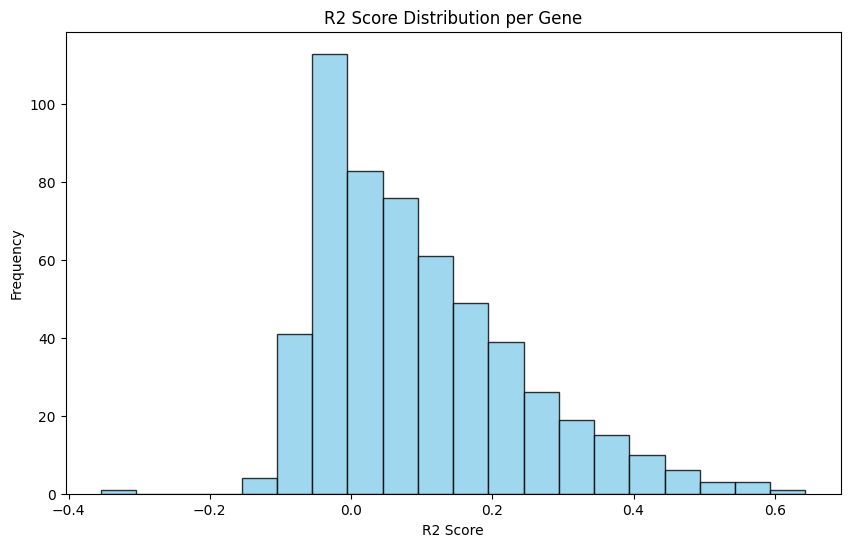

        gene  r2_score
49     Pvalb  0.643409
31      Gfap  0.589351
293  Ppp1r17  0.576248
10     Calb1  0.558126
208     Zic1  0.514993
..       ...       ...
192    Kcnj5 -0.108109
399     Ttc6 -0.110443
410     Lhx8 -0.122343
100    Gpr39 -0.146031
119     Fli1 -0.354190

[550 rows x 2 columns]


In [38]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(10,6))
plt.hist(preds_test_per_gene['r2_score'], bins=20, alpha=0.8, color='skyblue', edgecolor='black')
plt.title('R2 Score Distribution per Gene')
plt.xlabel('R2 Score')
plt.ylabel('Frequency')
plt.show()

# Sorting by r2_score
preds_test_per_gene = preds_test_per_gene.sort_values(by='r2_score', ascending=False)

# Display the sorted DataFrame
print(preds_test_per_gene)


,gene,r2_score
49,Pvalb,0.643409
31,Gfap,0.589351
293,Ppp1r17,0.576248
10,Calb1,0.558126
208,Zic1,0.514993
...,...,...
192,Kcnj5,-0.108109
399,Ttc6,-0.110443
410,Lhx8,-0.122343
100,Gpr39,-0.146031


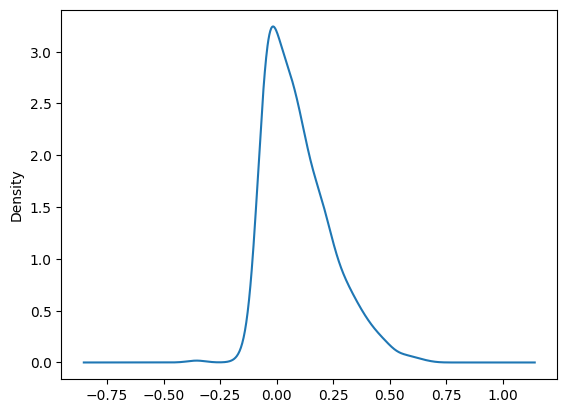

In [39]:
preds_test_per_gene

# plot r2 score distribution per gene, histogram
# density plot
preds_test_per_gene.r2_score.plot.kde()
#preds_test_per_gene.r2_score.plot.hist(bins=20, alpha=0.8)

# plot r2 score distribution per celltype, histogram
#preds_test_per_cell.r2_score.plot.hist(bins=10, alpha=0.8)

# sort by r2 score
preds_test_per_gene.sort_values(by='r2_score', ascending=False, inplace=True)
preds_test_per_gene

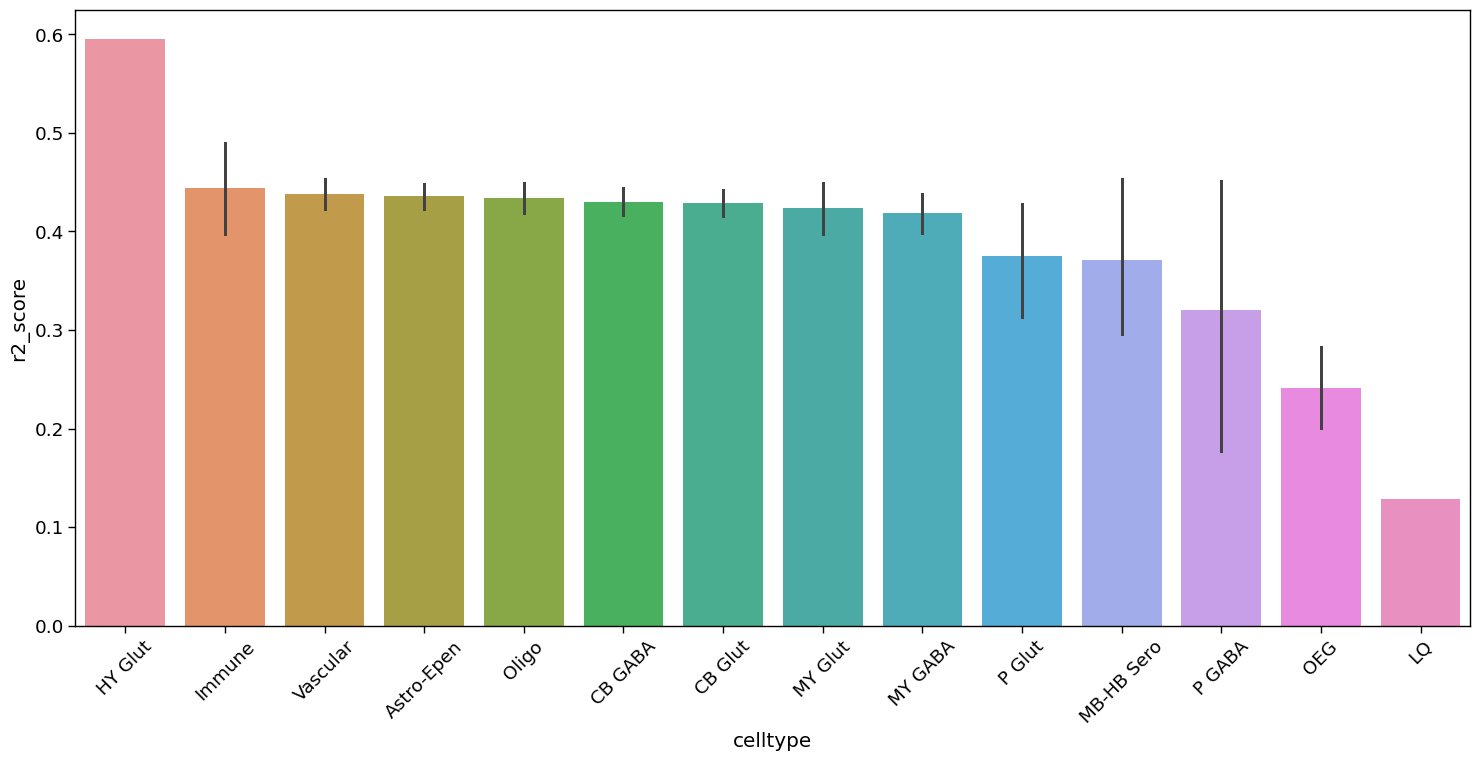

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# set style
sns.set_palette("colorblind")
sns.set_context("paper", font_scale=1.5)

# make plot larger
plt.figure(figsize=(18,8))

# rotate x-axis labels
plt.xticks(rotation=45)

# create plot of mean R2 score per celltype
# order bars by mean R2 score

# add avlue counts from adata.obs.class_label.value_counts()
ax = sns.barplot(x="celltype", y="r2_score", data=preds_test_per_cell, order=preds_test_per_cell.groupby('celltype').mean().sort_values(by='r2_score', ascending=False).index)

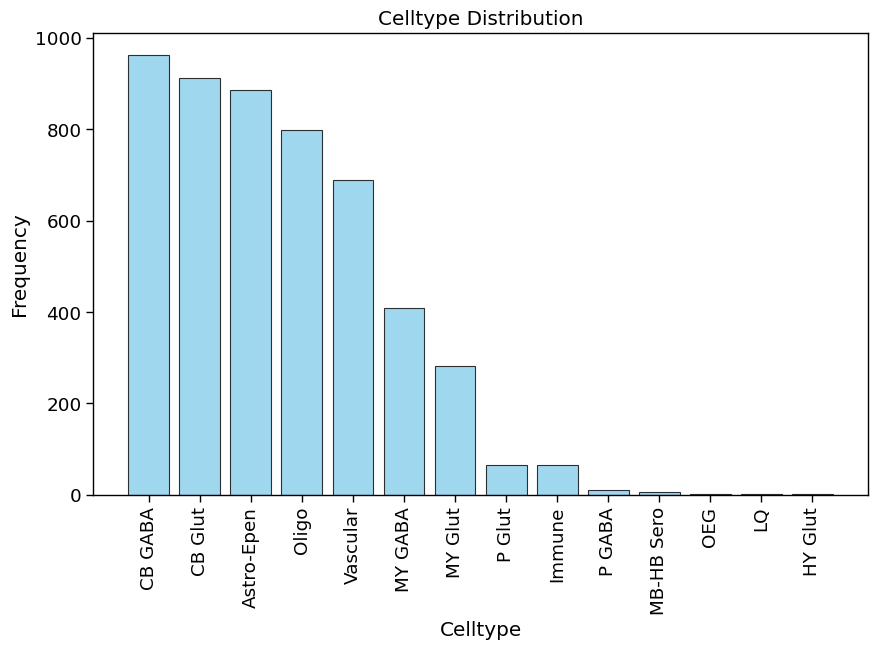

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the frequency of each celltype
celltype_counts = preds_test_per_cell['celltype'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.bar(celltype_counts.index, celltype_counts.values, alpha=0.8, color='skyblue', edgecolor='black')
plt.xticks(rotation='vertical')
plt.xticks(rotation=90)
plt.title('Celltype Distribution')
plt.xlabel('Celltype')
plt.ylabel('Frequency')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.violinplot(x="celltype", y="r2_score", data=preds_test_per_cell)
# rotate x-axis labels
plt.xticks(rotation=90)
plt.title('R2 Score Distribution per Gene')
plt.xlabel('R2 Score')
plt.show()


In [ ]:
file_path = "./data/subset_6img_atlas_brain.h5ad"
root_path = "./data"
dataset = InMemoryGraphDataset(root= root_path,
                               data_names = "data_test",
                               file_path=file_path, image_col="section", label_col="class_label", include_label=False, radius=20,node_level = 1, batch_size=1)



In [ ]:
# Load your dataset
import torch
data = torch.load('./data/data_test.pt')